In [1]:
"""
Created on Thu Jun 5 1:12 2025

@author: ach12345
"""

'\nCreated on Thu Jun 5 1:12 2025\n\n@author: ach12345\n'

In [1]:
# 🔧 Standard Library Imports
import os
import pickle
import time
from datetime import datetime

# 📦 Third-Party Library Imports
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import xarray as xr
import pyvista as pv
from IPython.display import Image
from scipy.io import savemat, loadmat
import h5py

# 🧠 Cedalion Core Imports
import cedalion
from cedalion import units, scos
import cedalion.io as cio
from cedalion import dataclasses as cdc
import cedalion.datasets as datasets
import cedalion.sigproc.quality as quality

# 🧱 Cedalion Geometry & Registration
import cedalion.geometry.registration
import cedalion.geometry.segmentation
import cedalion.geometry.landmarks as cgeolm
import cedalion.dataclasses.geometry as geo

# 🧬 Cedalion Image Reconstruction
import cedalion.imagereco.forward_model as fw
import cedalion.imagereco.tissue_properties
from cedalion.imagereco.solver import pseudo_inverse_stacked

# 📊 Cedalion Visualization & Plotting
import cedalion.plots
import cedalion.plots as cp
import cedalion.vis.plot_sensitivity_matrix
import cedalion.vis.plot_sensitivity_matrix as psm

# 🧠 Constants
HEAD_MODEL = 'colin27'
FORWARD_MODEL = "MCX"  # Options: "MCX", "NIRFASTER"
NUM_TAU = 2            # Options: 5, 128, 200
T_exp = 4000e-6        # Exposure time in seconds

# 🖼️ PyVista Backend Configuration
pv.set_jupyter_backend('static')


In [ ]:
#%% GET CURRENT DATE AND TIME
# Get the current date and time
now = datetime.now()

# Format the date and time as a string
date_time_str = now.strftime("%Y-%m-%d_%H-%M-%S")

In [ ]:
#%%
pick_file = 'BFi'
# pick_file = 'OD'

use_precomputed_sensitivity_matrix = False

In [ ]:
scos.test()
A = '🧠'
print(A)


this worked
🧠


In [ ]:
#%% FUNCTION DEFINITIONS
def gen_xform_from_pts(p1, p2):
    """
    given two sets of points, p1 and p2 in n dimensions,
    find the n-dims affine transformation matrix t, from p1 to p2.

    Source: https://github.com/bunpc/atlasviewer/blob/71fc98ec8ca54783378310304113e825bbcd476a/utils/gen_xform_from_pts.m#l4
    
    parameters:
    p1 : ndarray
        an array of shape (p, n) representing the first set of points.
    p2 : ndarray
        an array of shape (p, n) representing the second set of points.

    returns:
    t : ndarray
        the (n+1, n+1) affine transformation matrix.
    """
    p1, p2 = np.array(p1), np.array(p2)
    p = p1.shape[0]
    q = p2.shape[0]
    m = p1.shape[1]
    n = p2.shape[1]
    
    if p != q:
        raise ValueError('number of points for p1 and p2 must be the same')
    
    if m != n:
        raise ValueError('number of dimensions for p1 and p2 must be the same')
    
    if p < n:
        raise ValueError(f'cannot solve transformation with fewer anchor points ({p}) than dimensions ({n}).')
    
    t = np.eye(n + 1)
    a = np.hstack((p1, np.ones((p, 1))))
    
    for ii in range(n):
        x = np.linalg.pinv(a) @ p2[:, ii]
        t[ii, :] = x
        
    return t

In [ ]:
#%% load head model 

if HEAD_MODEL == 'colin27':    
    SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()
if HEAD_MODEL == 'icbm152':
    SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_icbm152_segmentation()

masks, t_ijk2ras = cedalion.io.read_segmentation_masks(SEG_DATADIR, mask_files)


head = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    brain_surface_file= os.path.join(SEG_DATADIR, "mask_brain.obj"),
    scalp_surface_file= os.path.join(SEG_DATADIR, "mask_scalp.obj"),
    landmarks_ras_file=landmarks_file,
    smoothing=0.5,
    fill_holes=True,
) 
head.scalp.units = cedalion.units.mm
head.brain.units = cedalion.units.mm

In [ ]:
#%% load recording


########## NOTE FOR ALEX: CHANGE THE FILE PATH TO BE WITHIN CEDALION WHEN WE MOVE THE SNIRF FILES THERE#################
if pick_file == 'BFi':
    rec2 = cio.read_snirf('SCOS_data_subj_fixed.snirf')[0]
    print('rec loaded BFi')
elif pick_file == 'OD':
    rec2 = cio.read_snirf('SCOS_data_subj_OD_fixed.snirf')[0]
    print('rec loaded OD')


# rec['amp'].time.attrs['units'] = units.s
rec2['hrf_conc'].time.attrs['units'] = units.s


rec loaded BFi


In [ ]:
#%% GET HRF MAG FROM HRF SNIRF
t_win = [10,15]

hrf_mag2 = rec2['hrf_conc'].sel(time=slice(t_win[0], t_win[1]),chromo='HbO').mean('time')
hrf_mag_to_plot = xr.where(np.isnan(hrf_mag2), 1e-16, hrf_mag2 )
hrf_mag_to_plot = xr.where(np.isinf(hrf_mag2), 1e-16, hrf_mag_to_plot)

c:\Users\ach12345\AppData\Local\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\GitHub\cedalion\src\cedalion\geometry\landmarks.py:233: UserWarning: WIP: distance calculation around ears
  warnings.warn("WIP: distance calculation around ears")


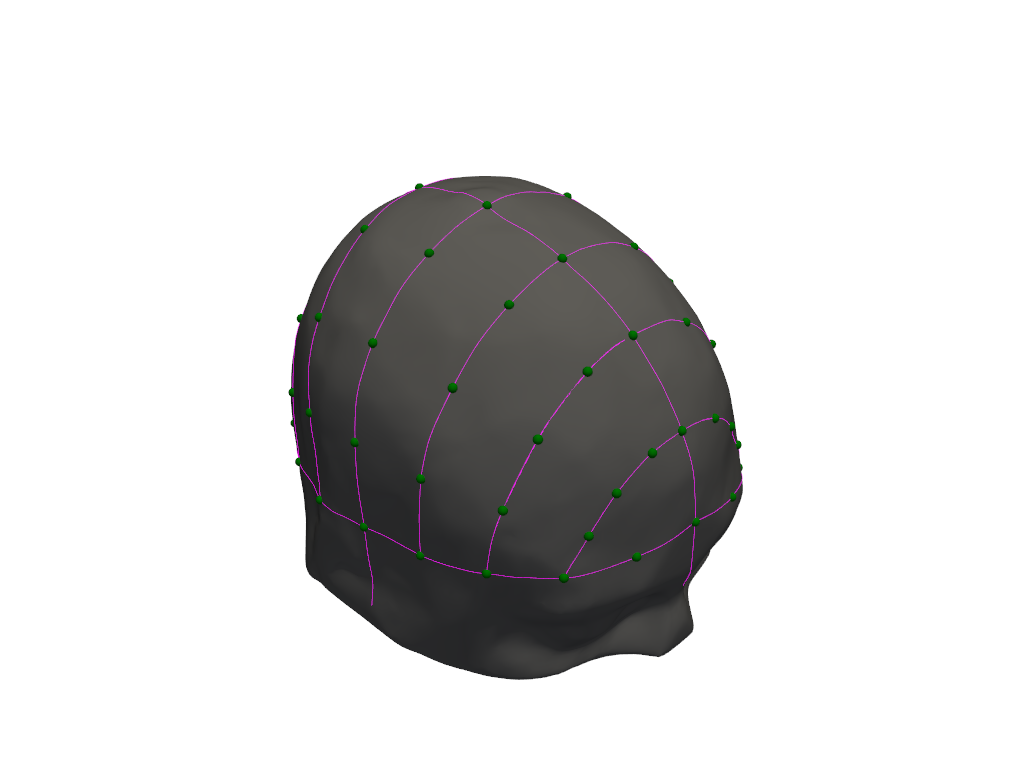

In [ ]:
#%% Load individual head data
# Build the 10-10 system landmarks from the fiducials and the scalp using cedalions LandmarksBuilder1010
scalp_surface = head.scalp

# Align fiducials to head coordinate system
fiducials_ras = cio.read_mrk_json(os.path.join(SEG_DATADIR, landmarks_file), crs="aligned")
fiducials_ijk = fiducials_ras.points.apply_transform(np.linalg.pinv(t_ijk2ras))
# Compute landmarks by EEG's 1010 system rules
lmbuilder = cgeolm.LandmarksBuilder1010(scalp_surface, fiducials_ijk)
all_landmarks = lmbuilder.build()
lmbuilder.plot()

c:\Users\ach12345\AppData\Local\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


73 Landmarks used for co-registration:
 ['FCz', 'TP7', 'Fpz', 'F3', 'F5', 'F8', 'P7', 'FC4', 'AF3', 'Cz', 'Nz', 'P8', 'Fp1', 'P5', 'P4', 'Iz', 'T8', 'AF5', 'AF7', 'F2', 'TP8', 'FT7', 'PO3', 'PO4', 'C1', 'Oz', 'AF1', 'FC2', 'AF2', 'Pz', 'PO7', 'O1', 'CP1', 'CP5', 'P2', 'P3', 'RPA', 'C5', 'C2', 'FC3', 'PO8', 'O2', 'CP4', 'P6', 'PO6', 'CP3', 'PO5', 'POz', 'F6', 'CPz', 'PO2', 'F4', 'F7', 'Fz', 'P1', 'FC1', 'AF6', 'C6', 'CP6', 'T7', 'FT8', 'F1', 'FC5', 'AF4', 'CP2', 'Fp2', 'AF8', 'C3', 'LPA', 'C4', 'FC6', 'AFz', 'PO1']


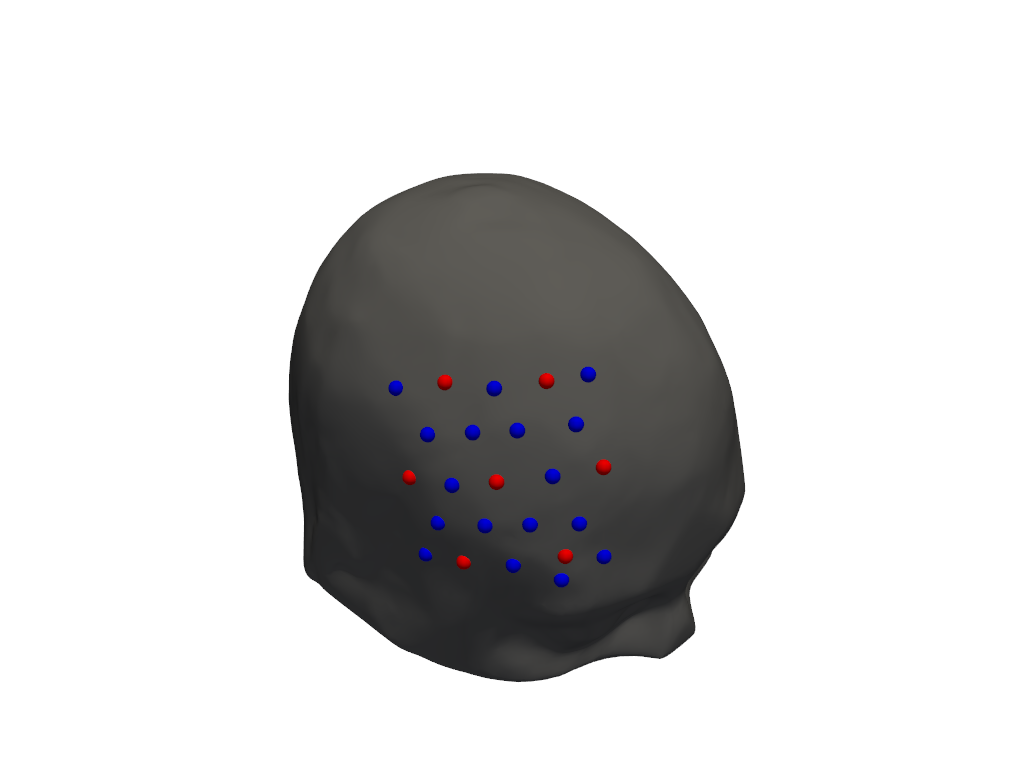

In [ ]:
#%% ALIGN PROBE
geo3d = rec2.geo3d
ninjacap_optodes = geo3d.loc[(geo3d.type==geo.PointType.SOURCE) | (geo3d.type==geo.PointType.DETECTOR)]    
ninjacap_landmarks = geo3d.loc[geo3d.type==geo.PointType.LANDMARK]    
meas_list = rec2._measurement_lists['hrf_conc']

fiducials_ras = cio.read_mrk_json(os.path.join(SEG_DATADIR, landmarks_file), crs="aligned")

# Individial landmarks
individual_ref_pos = np.array(all_landmarks)  
individual_ref_labels = [lab.item() for lab in all_landmarks.label] 

# Load ninja cap data
#ninjacap_optodes, ninjacap_landmarks, meas_list = cedalion.datasets.get_ninja_cap_probe() 
ninja_ref_pos = list(np.array(ninjacap_landmarks.values))
ninja_ref_labels = list(np.array(ninjacap_landmarks.label))

# Construct transform from intersection
intersection = list(set(ninja_ref_labels) & set(individual_ref_labels)) 
individual_ref_pos = [individual_ref_pos[individual_ref_labels.index(intsct)] for intsct in intersection]
ninja_ref_pos = [ninja_ref_pos[ninja_ref_labels.index(intsct)] for intsct in intersection]
print("%d Landmarks used for co-registration:\n" % len(intersection), intersection)

T = gen_xform_from_pts(ninja_ref_pos, individual_ref_pos) # get affine  

# Apply transform
ninja_aligned = ninjacap_optodes.points.apply_transform(T)
# Snap to surface

ninja_aligned = ninja_aligned.rename({'pos':'ijk'})

ninja_snapped_aligned = head.scalp.snap(ninja_aligned)
# Plot
p = pv.Plotter()
cedalion.plots.plot_surface(p, head.scalp)
cedalion.plots.plot_labeled_points(p, ninja_snapped_aligned)
p.show()

In [ ]:
if use_precomputed_sensitivity_matrix:
    print("Using precomputed sensitivity matrix.")
    # load in A
    if pick_file == "BFi":
        with open("2025-02-25_13-19-28_sensitivity_matrix_rytov_xr.pickle", "rb") as f:
            A_scos = pickle.load(f)
            print("A loaded BFi")
    elif pick_file == "OD":
        with open("2025-01-09_14-15-07_sensitivity_matrix_od.pickle", "rb") as f:
            A_scos = pickle.load(f)
            print("A loaded OD")
else:
    print("Generating sensativity matrix.")
    fwm = cedalion.imagereco.forward_model.ForwardModel(
        head, ninja_snapped_aligned, meas_list
    )
    scos.compute_autocorrelation_mcx(
        fwm=fwm,
        date_time_str=date_time_str,
        aDb=np.array(
            [
                1e-6,
                1e-6,
                6e-6,
                1e-6,
                1e-6,
                6e-6,
            ]
        ),
        wavelength=852e-6,
        n=1.33,
        T_exp=4000e-6,
        NUM_TAU=NUM_TAU,
    )
    A_scos = scos.compute_sensitivity_scos(
        fwm=fwm,
        rec=rec2,
        date_time_str=date_time_str,
        aDb=np.array(
            [
                1e-6,
                1e-6,
                6e-6,
                1e-6,
                1e-6,
                6e-6,
            ]
        ),
        wavelength=852e-6,
        n=1.33,
        T_exp=4000e-6,
        NUM_TAU=NUM_TAU,
        dDb=1e-7,
        S=1,
        v=1,
        beta=1,
    )


Using precomputed sensitivity matrix.
A loaded BFi


In [ ]:
fwm = cedalion.imagereco.forward_model.ForwardModel(head, ninja_snapped_aligned, meas_list)

help(fwm.compute_sensitivity)

Help on method compute_sensitivity in module cedalion.imagereco.forward_model:

compute_sensitivity(fluence_all, fluence_at_optodes) method of cedalion.imagereco.forward_model.ForwardModel instance
    Compute sensitivity matrix from fluence.
    
    Args:
        fluence_all (xr.DataArray): Fluence in each voxel for each wavelength.
        fluence_at_optodes (xr.DataArray): Fluence at all optode positions for each
            wavelength.
    
    Returns:
        xr.DataArray: Sensitivity matrix for each channel, vertex and wavelength.



In [ ]:
#%% get the inverse of A_xr and do image recon 


# if OD then A_scos should have brain and scalp, extract only brain. 
if pick_file == 'OD':
    A_scos_brain = A_scos[:,A_scos.is_brain.values]
    print('Brain only extracted because OD')
# if BFi then A_scos should have brain only so no need to extract
elif pick_file == 'BFi':
    A_scos_brain = A_scos
    print('Whole matrix used because BFi')

# A_normalized = (A_scos_brain - A_scos_brain.min())/A_scos_brain.max()
A_normalized = A_scos_brain

my_alpha = 0.01
B = pseudo_inverse_stacked(A_normalized.squeeze(), alpha = my_alpha)

# image1 = B.values @ hrf_mag_to_plot.sel(trial_type = '1').values.reshape([hrf_mag.shape[1],1])
# image2 = B.values @ hrf_mag_to_plot.sel(trial_type = '2').values.reshape([hrf_mag.shape[1],1])
image1 = B.values @ hrf_mag_to_plot.sel(trial_type = '1').values
image2 = B.values @ hrf_mag_to_plot.sel(trial_type = '2').values
image1_og = B.values @ hrf_mag_to_plot.sel(trial_type = '1').values
image2_og = B.values @ hrf_mag_to_plot.sel(trial_type = '2').values

Whole matrix used because BFi


c:\Users\ach12345\AppData\Local\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


c:\Users\ach12345\AppData\Local\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


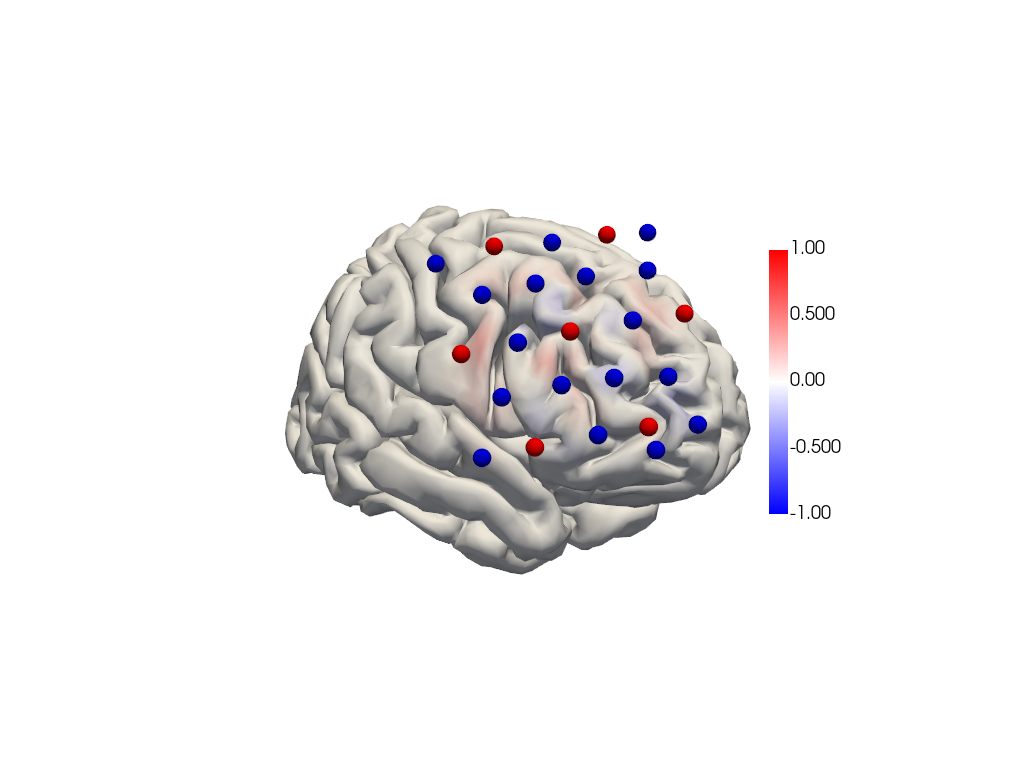

In [ ]:
#%% plot the image  easy
image1 = image1_og/image2_og.max()
image2 = image2_og/image2_og.max()
# choose to save or to look,                need to also change p.show 
# p = pv.Plotter(off_screen=True)                       # for saving
p = pv.Plotter()                                        # for looking

# image2_brain = image2[A_scos.is_brain.values]
# image1_brain = image1[A_scos.is_brain.values]

# for clim use + max to - max  if the scaling is correct
#clim =[min([image1.min(), image2.min()]), max([image1.max(), image2.max()])]
clim =[-max([image1.max(), image2.max()]), max([image1.max(), image2.max()])]

cmap = plt.get_cmap("bwr", 256)

gray = [1, 1, 1, 1]  # RGBA for gray
new_cmap_colors = np.vstack((cmap(np.linspace(0, 1, 256))))
new_cmap_colors[126:130,:] = gray
custom_cmap = ListedColormap(new_cmap_colors)

# if don't want to cut out middle
custom_cmap = cmap

b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)
# change scalars to be image 1 or 2 based on which one you want to see
p.add_mesh(b, scalars=image1, cmap=custom_cmap,
                  smooth_shading=True, clim=clim,
                  scalar_bar_args={'shadow':True, 'vertical': True, 'position_y': 0.325, 'position_x': 0.75, 'height': 0.35, 'width': 0.05})


# change the location for s7
ninja_snapped_aligned.loc['S7'] = np.array([150,193,75])*units.millimeter

# plot probe points
cedalion.plots.plot_labeled_points(p, ninja_snapped_aligned)

# position camera
cog = head.brain.vertices.mean("label").values
pos = np.array([300, 0, 0])                                         
p.camera.position = cog + pos
p.camera.focal_point = cog 
p.camera.up = [0,0,10] 

p.reset_camera()

p.camera.Azimuth(30)



#p.save_graphic(f'/ad/eng/research/eng_research_boas/BOAS SCOS/2023 multi channel fbSCOS/paper/figures/R2/{pick_file}_easy_alpha_{my_alpha}_20250514.svg')
#p.save_graphic(f'/ad/eng/research/eng_research_boas/BOAS SCOS/2023 multi channel fbSCOS/paper/figures/R2/{pick_file}_easy_alpha_{my_alpha}_20250514.png')



p.show()        
# # Ensure the plotter is open before setting the window size
# if not p.ren_win:
#     p.show(auto_close=False)                                            # for looking

# SAVE THE SCREENSHOT
# p.show(screenshot='BFi_hard20250113.png')                          # for saving
# p.screenshot(f'{pick_file}_hard20250113.png',window_size=(3000,3000),scale = 10, transparent_background=True)

c:\Users\ach12345\AppData\Local\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


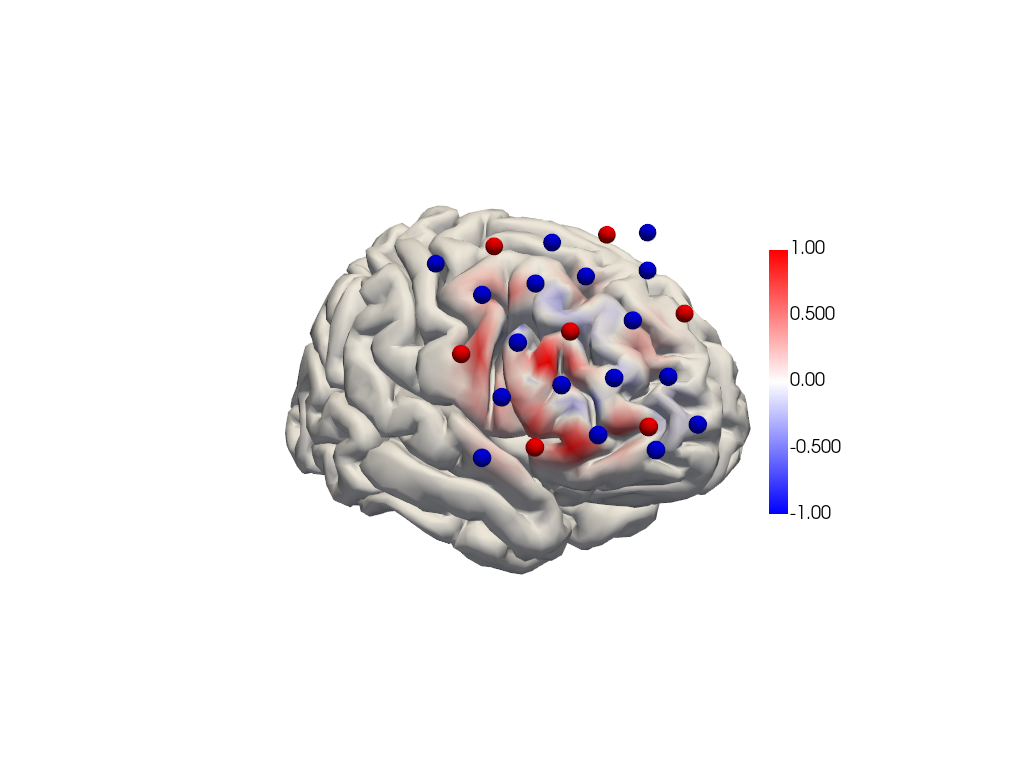

In [ ]:

#%% plot the image  hard
image2 = image2_og/image2_og.max()
# choose to save or to look,                need to also change p.show 
# p = pv.Plotter(off_screen=True)                       # for saving
p = pv.Plotter()                                        # for looking

# image2_brain = image2[A_scos.is_brain.values]
# image1_brain = image1[A_scos.is_brain.values]

# for clim use + max to - max  if the scaling is correct
#clim =[min([image1.min(), image2.min()]), max([image1.max(), image2.max()])]
clim =[-max([image1.max(), image2.max()]), max([image1.max(), image2.max()])]

cmap = plt.get_cmap("bwr", 256)

gray = [1, 1, 1, 1]  # RGBA for gray
new_cmap_colors = np.vstack((cmap(np.linspace(0, 1, 256))))
new_cmap_colors[126:130,:] = gray
custom_cmap = ListedColormap(new_cmap_colors)

# if don't want to cut out middle
custom_cmap = cmap

b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)
# change scalars to be image 1 or 2 based on which one you want to see
p.add_mesh(b, scalars=image2, cmap=custom_cmap,
                  smooth_shading=True, clim=clim,
                  scalar_bar_args={'shadow':True, 'vertical': True, 'position_y': 0.325, 'position_x': 0.75, 'height': 0.35, 'width': 0.05})
# plot probe points
cedalion.plots.plot_labeled_points(p, ninja_snapped_aligned)

# position camera
cog = head.brain.vertices.mean("label").values
pos = np.array([300, 0, 0])                                         
p.camera.position = cog + pos
p.camera.focal_point = cog 
p.camera.up = [0,0,10] 

p.reset_camera()

p.camera.Azimuth(30)



#p.save_graphic(f'/ad/eng/research/eng_research_boas/BOAS SCOS/2023 multi channel fbSCOS/paper/figures/R2/{pick_file}_hard_alpha_{my_alpha}_20250514.svg')
#p.save_graphic(f'/ad/eng/research/eng_research_boas/BOAS SCOS/2023 multi channel fbSCOS/paper/figures/R2/{pick_file}_hard_alpha_{my_alpha}_20250514.png')



p.show()        
# # Ensure the plotter is open before setting the window size
# if not p.ren_win:
#     p.show(auto_close=False)                                            # for looking

# SAVE THE SCREENSHOT
# p.show(screenshot='BFi_hard20250113.png')                          # for saving
# p.screenshot(f'{pick_file}_hard20250113.png',window_size=(3000,3000),scale = 10, transparent_background=True)



c:\Users\ach12345\AppData\Local\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


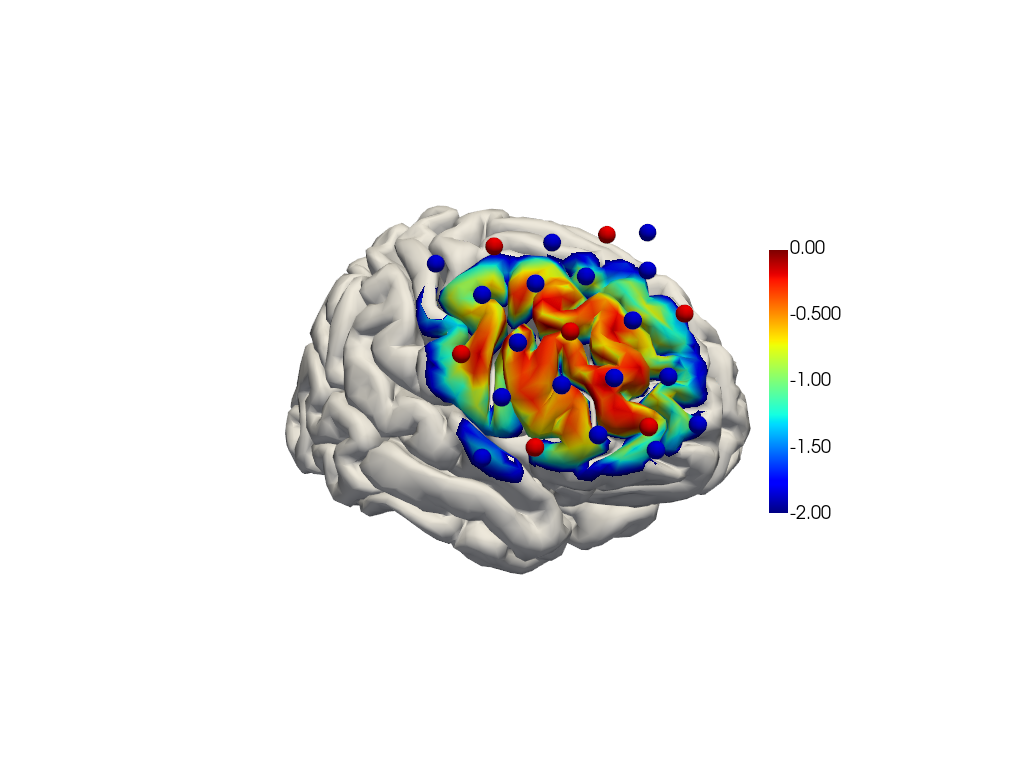

In [ ]:
#%% plot the image  of Sensitivity matrix log with color bar fix
imageA = sum(A_normalized.squeeze())
imageA = np.log10(imageA/imageA.max())
# choose to save or to look,                need to also change p.show 
# p = pv.Plotter(off_screen=True)                       # for saving
p = pv.Plotter()                                        # for looking

# image2_brain = image2[A_scos.is_brain.values]
# image1_brain = image1[A_scos.is_brain.values]

# for clim use + max to - max  if the scaling is correct
#clim =[min([image1.min(), image2.min()]), max([image1.max(), image2.max()])]
# clim =[-max([image1.max(), image2.max()]), max([image1.max(), image2.max()])]
clim = [-2,0]

cmap = plt.get_cmap("jet", 256)

gray = [1, 1, 1, 1]  # RGBA for gray
new_cmap_colors = np.vstack((cmap(np.linspace(0, 1, 256))))
# new_cmap_colors[126:130,:] = gray
new_cmap_colors[0,:] = gray
custom_cmap = ListedColormap(new_cmap_colors)

# if don't want to cut out middle
# custom_cmap = cmap

b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)
# change scalars to be image 1 or 2 based on which one you want to see
p.add_mesh(b, scalars=imageA, cmap=custom_cmap,
                  smooth_shading=True, clim=clim,
                  scalar_bar_args={'shadow':True, 'vertical': True, 'position_y': 0.325, 'position_x': 0.75, 'height': 0.35, 'width': 0.05})
# plot probe points
cedalion.plots.plot_labeled_points(p, ninja_snapped_aligned)

# position camera
cog = head.brain.vertices.mean("label").values
pos = np.array([300, 0, 0])                                         
p.camera.position = cog + pos
p.camera.focal_point = cog 
p.camera.up = [0,0,10] 

p.reset_camera()

p.camera.Azimuth(30)



#p.save_graphic(f'{pick_file}_sensitivity_matrix_20250116.svg')



p.show()        
# # Ensure the plotter is open before setting the window size
# if not p.ren_win:
#     p.show(auto_close=False)                                            # for looking

# SAVE THE SCREENSHOT
# p.show(screenshot='BFi_hard20250113.png')                          # for saving
# p.screenshot(f'{pick_file}_hard20250113.png',window_size=(3000,3000),scale = 10, transparent_background=True)